In [144]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import torchvision
from pylab import *
import re
from PIL import ImageOps
import itertools
import functools
import operator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import KernelPCA
from torch.optim import lr_scheduler



In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [171]:
batch_size = 8
learning_rate = 1e-3 # 1e-2
num_epochs = 1000

In [185]:
data = pd.read_csv('data/LH_KPCA_5_highRes.csv').drop(columns='mass')
data['shapes'] = (data['shapes']).astype(np.float32)
data['diameter'] = (data['diameter']).astype(np.float32)
data['fall_velocity'] = (data['fall_velocity']).astype(np.float32)
data['air_density'] = (data['air_density']).astype(np.float32)
data['Reynolds Number'] = (data['Reynolds Number']).astype(np.float32)
data['KPCA1'] = (data['KPCA1']).astype(np.float32)
data['KPCA2'] = (data['KPCA2']).astype(np.float32)
data['KPCA3'] = (data['KPCA3']).astype(np.float32)
data['KPCA4'] = (data['KPCA4']).astype(np.float32)
data['KPCA5'] = (data['KPCA5']).astype(np.float32)

data = data.drop(columns=['Unnamed: 0'])
data['Drag Coefficient'] = (data['Drag Coefficient']).astype(np.float32)
data = data.drop([data.index[110]], inplace=False).reset_index().drop(columns='index') # has drag > 4
data['Re_unscaled'] = data['Reynolds Number']
data['id'] = data.index

scaler = StandardScaler()

#data[['Reynolds Number', 'KPCA1']] = scaler.fit_transform(data[['Reynolds Number', 'KPCA1']])
#data[['Reynolds Number', 'KPCA1', 'KPCA2', 'KPCA3']] = scaler.fit_transform(data[['Reynolds Number', 'KPCA1', 'KPCA2', 'KPCA3']])
data[['Reynolds Number', 'KPCA1', 'KPCA2', 'KPCA3', 'KPCA4', 'KPCA5']] = scaler.fit_transform(data[['Reynolds Number', 'KPCA1', 'KPCA2', 'KPCA3', 'KPCA4', 'KPCA5']])


In [173]:
data

,Drag Coefficient,diameter,fall_velocity,air_density,air_viscosity,Reynolds Number,shapes,KPCA1,KPCA2,KPCA3,Re_unscaled,id
0,1.509814,0.002136,1.03,1.112,0.000018,-0.398748,14.0,-0.922873,-0.129363,-1.203811,139.155777,0
1,0.772313,0.002055,1.93,1.112,0.000018,0.366882,14.0,-0.327650,0.041418,-0.513190,250.869568,1
2,0.460777,0.003011,2.54,1.112,0.000018,1.963325,14.0,1.291081,2.139721,0.670459,483.808044,2
3,0.354451,0.001646,2.01,1.112,0.000018,0.082010,14.0,-1.181696,0.780322,-0.788736,209.303650,3
4,0.644595,0.006918,1.69,1.112,0.000018,3.715550,6.0,-0.060557,2.328631,-0.634736,739.476929,4
...,...,...,...,...,...,...,...,...,...,...,...,...
122,1.997184,0.001798,1.00,1.112,0.000018,-0.573058,14.0,-1.095075,-0.317799,0.604626,113.722054,122
123,0.472535,0.001990,2.30,1.112,0.000018,0.632141,15.0,-0.653439,-1.199220,-0.784993,289.573761,123
124,0.994761,0.004031,1.40,1.112,0.000018,1.093994,3.0,0.481949,1.228456,-0.001846,356.963135,124
125,0.784335,0.001575,1.20,1.112,0.000018,-0.533126,13.0,1.023146,0.789093,-0.963814,119.548500,125


In [186]:
class LH(torch.utils.data.Dataset):
    def __init__(self, data):
        self.RE = data['Reynolds Number']
        self.shape = data['shapes']
        self.PCA1 = data['KPCA1']
        self.PCA2 = data['KPCA2']
        self.PCA3 = data['KPCA3']
        self.PCA4 = data['KPCA4']
        self.PCA5 = data['KPCA5']
        self.y = data['Drag Coefficient']
        self.id = data['id']

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        RE = torch.tensor(self.RE[idx], dtype=torch.float32)
        shape = torch.tensor(self.shape[idx], dtype=torch.float32)
        PCA1 = torch.tensor(self.PCA1[idx], dtype=torch.float32)
        PCA2 = torch.tensor(self.PCA2[idx], dtype=torch.float32)
        PCA3 = torch.tensor(self.PCA3[idx], dtype=torch.float32)
        PCA4 = torch.tensor(self.PCA4[idx], dtype=torch.float32)
        PCA5 = torch.tensor(self.PCA5[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        id = torch.tensor(self.id[idx], dtype=torch.float32)
        
       # return data, y
        #return torch.tensor([RE, shape, PCA1, PCA2, PCA3]), y, id
        return torch.tensor([RE, shape, PCA1, PCA2, PCA3, PCA4, PCA5]), y, id



In [187]:
full_data = LH(data)

train_size = int(0.75 * len(full_data))
test_size = len(full_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_data, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [188]:

class MLP(nn.Module):
  
  def __init__(self):
    super(MLP, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(3, 7),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(7, 15),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(15, 31),
      nn.ReLU(),
      nn.Linear(31, 15), 
      nn.ReLU(),
      nn.Linear(15, 7),
      nn.ReLU(),
      nn.Linear(7, 3),
      nn.ReLU(),
      nn.Linear(3, 1),
    )

  def forward(self, x):
    return self.layers(x)  
  
  
class MLP3(nn.Module):
  
  def __init__(self):
    super(MLP3, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(5, 11),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(11, 23),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(23, 47),
      nn.ReLU(),
      nn.Linear(47, 23), 
      nn.ReLU(),
      nn.Linear(23, 11),
      nn.ReLU(),
      nn.Linear(11, 5),
      nn.ReLU(),
      nn.Linear(5, 1),
    )

  def forward(self, x):
    return self.layers(x)  
  
class MLP5(nn.Module):

  def __init__(self):
    super(MLP5, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(7, 15),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(15, 31),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(31, 63),
      nn.ReLU(),
      nn.Linear(63, 31), 
      nn.ReLU(),
      nn.Linear(31, 15),
      nn.ReLU(),
      nn.Linear(15, 7),
      nn.ReLU(),
      nn.Linear(7, 1),
    )

  def forward(self, x):
    return self.layers(x)  

In [194]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Defining our model and training our model

model = MLP5().to(device)  # Create an instance of the model
#optimizer =  torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # Choose an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()  # Mean squared error loss
train_loss_list = []
test_loss_list = []
best_test_MSE = 100

lr_step_size = 30
lr_gamma = 0.5
scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
# Training loop 

for epoch in range(num_epochs):
    model.train()  # Set the model in training mode
    train_loss = 0.0
    scheduler.step()

    for X, y, _ in train_loader:
        X = Variable(X, requires_grad=True)
        y = Variable(y)
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)
       
        # Backward pass and optimization
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)
    # Evaluation
    model.eval()  # Set the model in evaluation mode
    test_loss = 0.0

    with torch.no_grad():
        for X, y, _ in test_loader:
            X = Variable(X, requires_grad=True)
            y = Variable(y)
            
            # Forward pass
            outputs = model(X)
            loss = criterion(outputs[0], y)
        
            # Backward pass and optimization
            # optimizer.zero_grad() 
            # loss.backward()
            # optimizer.step()

            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)
    test_loss_list.append(test_loss)

    if test_loss < best_test_MSE:
        best_test_MSE = test_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f} - Test Loss: {test_loss:.6f}")

print(f'Best test MSE : {best_test_MSE}')

torch.save(best_model_state, '/Users/cameronhudson/Documents/Masters/Research/Snow/LH_models/LH_5k_5MLP.model')
torch.save(test_loader, '/Users/cameronhudson/Documents/Masters/Research/Snow/LH_models/LH_5k_5MLP.pth')

/Users/cameronhudson/Documents/Masters/Research/Snow/snow/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/Users/cameronhudson/Documents/Masters/Research/Snow/snow/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cameronhud

Epoch 1/1000 - Train Loss: 0.199279 - Test Loss: 0.215102
Epoch 2/1000 - Train Loss: 0.174612 - Test Loss: 0.182978
Epoch 3/1000 - Train Loss: 0.118779 - Test Loss: 0.107872
Epoch 4/1000 - Train Loss: 0.058504 - Test Loss: 0.085093


Epoch 5/1000 - Train Loss: 0.051934 - Test Loss: 0.081900
Epoch 6/1000 - Train Loss: 0.050877 - Test Loss: 0.079104
Epoch 7/1000 - Train Loss: 0.049939 - Test Loss: 0.076868
Epoch 8/1000 - Train Loss: 0.048379 - Test Loss: 0.076707
Epoch 9/1000 - Train Loss: 0.048564 - Test Loss: 0.072561
Epoch 10/1000 - Train Loss: 0.043374 - Test Loss: 0.073519
Epoch 11/1000 - Train Loss: 0.044923 - Test Loss: 0.072048
Epoch 12/1000 - Train Loss: 0.048742 - Test Loss: 0.072181
Epoch 13/1000 - Train Loss: 0.048538 - Test Loss: 0.068960
Epoch 14/1000 - Train Loss: 0.044446 - Test Loss: 0.064997
Epoch 15/1000 - Train Loss: 0.045851 - Test Loss: 0.068545
Epoch 16/1000 - Train Loss: 0.042506 - Test Loss: 0.062183
Epoch 17/1000 - Train Loss: 0.043211 - Test Loss: 0.061719
Epoch 18/1000 - Train Loss: 0.044119 - Test Loss: 0.064325
Epoch 19/1000 - Train Loss: 0.043057 - Test Loss: 0.061988
Epoch 20/1000 - Train Loss: 0.041389 - Test Loss: 0.058863
Epoch 21/1000 - Train Loss: 0.041026 - Test Loss: 0.059776
Ep

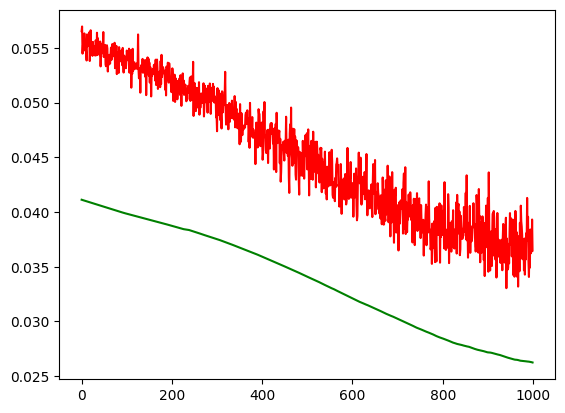

In [131]:
plt.plot(train_loss_list, 'r', test_loss_list, 'g') # 1e-4 5 fe

In [198]:
# # model_load = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_test3.model', map_location=torch.device('cpu'))
# model_load = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_test4.model', map_location=torch.device('cpu')) # 0.1952
# model_load1 = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_test5.model', map_location=torch.device('cpu')) # 0.1629 1000 epochs 7 layers, 5 hidden
# model_load2 = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_test6.model', map_location=torch.device('cpu')) # 0.1640 1000 epochs 5 layers, 3 hidden
# model_load3 = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_test7.model', map_location=torch.device('cpu')) # 0.1664 1000 epochs 9 layers, 7 hidden
# model_load4= torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_test8.model', map_location=torch.device('cpu')) # 0.0023 10000 epochs 7 layers, 5 hidden
# model_load5= torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_test9.model', map_location=torch.device('cpu')) # 0.0715 10000 epochs 7 layers 5 hidden (PCA, Re, Shape)

# fe_3 = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_3_fe_1e-3.model', map_location=torch.device('cpu'))
# fe_5_e4 = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_5_fe_1e-4.model', map_location=torch.device('cpu'))
# fe_5_e3 = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_5_fe_1e-3.model', map_location=torch.device('cpu'))

model_loc = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_models/LH_5k_5MLP.model', map_location=torch.device('cpu'))
test_loader = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_models/LH_5k_5MLP.pth', map_location=torch.device('cpu'))
model = MLP5()
model.load_state_dict(model_loc)

<All keys matched successfully>

In [196]:
y_test = [dat.item() for data in test_loader for dat in data[1]]
test_data = [dat for data in test_loader for dat in data[0]]

y_test_ids = [dat.item() for data in test_loader for dat in data[2]]

LH_test = data.loc[y_test_ids]

full_LH = pd.read_csv('/Users/cameronhudson/Documents/Masters/Research/Snow/data/LHDataClean.csv')
full_LH = full_LH[['Mass [kg]', 'Drag Coefficient']]
full_LH['Drag Coefficient'] = (full_LH['Drag Coefficient']).astype(np.float32)

LH_test = pd.merge(LH_test, full_LH, on='Drag Coefficient', how='left')

testing_data = LH_test[['Reynolds Number', 'shapes', 'KPCA1', 'KPCA2', 'KPCA3', 'KPCA4', 'KPCA5']]
testing_data = [torch.tensor(row.values) for _, row in testing_data.iterrows()]

y_pred = []
for i in testing_data:
    y_pred.append(model(i).item())

LH_test['y_pred'] = y_pred

In [199]:
print(model)

MLP5(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=15, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=15, out_features=31, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=31, out_features=63, bias=True)
    (7): ReLU()
    (8): Linear(in_features=63, out_features=31, bias=True)
    (9): ReLU()
    (10): Linear(in_features=31, out_features=15, bias=True)
    (11): ReLU()
    (12): Linear(in_features=15, out_features=7, bias=True)
    (13): ReLU()
    (14): Linear(in_features=7, out_features=1, bias=True)
  )
)


In [197]:
print('Our Model: ' + str(np.mean([abs(i-j)**2 for i,j in zip(y_pred, y_test)])))


Our Model: 0.3202648993750884


Text(0.5, 1.0, 'LH Dataset Drag Prediction vs Drag Coefficient on Test Dataset')

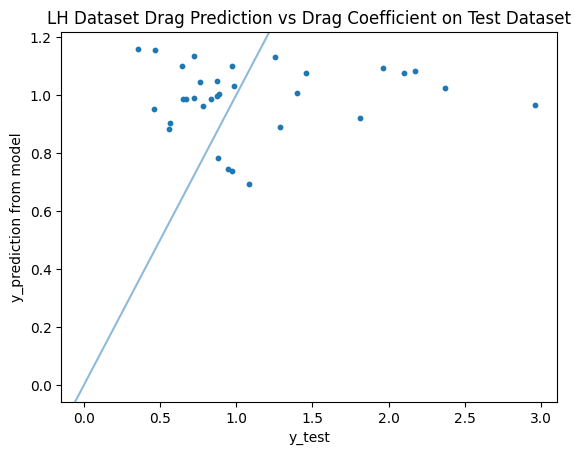

In [164]:
plt.scatter(LH_test['Drag Coefficient'], y_pred, s=10)
plt.axline((0, 0), slope=1, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_prediction from model') # fe_5_e4"
plt.title('LH Dataset Drag Prediction vs Drag Coefficient on Test Dataset')

Text(0.5, 1.0, 'LH Dataset Drag Prediction vs Drag Coefficient on Test Dataset')

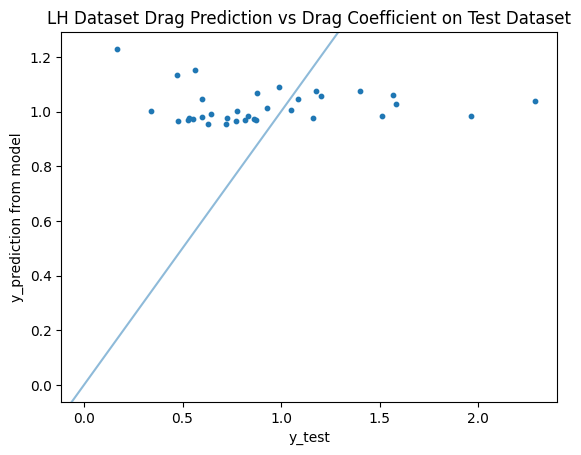

In [300]:


error = []
y_pred = []
y_test = []

for data in fe_5_test_loader:
    for dat in data[1]:
        y_test.append(dat.item())


for data in fe_5_test_loader:
    for dat in data[0]:
        pred = model(dat)
        y_pred.append(float(pred))


for i in range(len(y_test)):
    error.append(float(y_test[i] - y_pred[i])**2)

plt.scatter(y_test, y_pred, s=10)
plt.axline((0, 0), slope=1, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_prediction from model') # fe_5_e4"
plt.title('LH Dataset Drag Prediction vs Drag Coefficient on Test Dataset')

Text(0.5, 1.0, 'LH Dataset Drag Prediction vs Drag Coefficient on TRAIN Dataset')

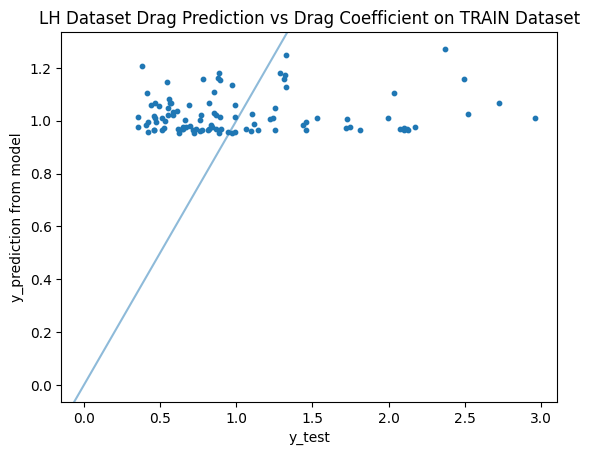

In [223]:
error = []
y_pred = []
y_test = []
for data in train_loader:
    for dat in data[1]:
        y_test.append(dat.item())

for data in train_loader:
    for dat in data[0]:
        pred = model(dat)
        y_pred.append(float(pred))


for i in range(len(train_loader)):
    error.append(float(y_test[i] - y_pred[i])**2)

plt.scatter(y_test, y_pred, s=10)
plt.axline((0, 0), slope=1, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_prediction from model') # fe_5_e4
plt.title('LH Dataset Drag Prediction vs Drag Coefficient on TRAIN Dataset')

In [227]:
shape_classes = pd.read_csv('LH_shapes.csv')

shape_dict = {'shapeClass' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
              'shapeName' : ['bALP7a', 'bALS3', 'bAP7a', 'bAR2b', 'bAS3', 'bHP7b', 'bR1a', 'bR1b', 'bR2a', 'bR2b', 'rR3a', 'bR3b', 'bR4a', 'bR4b', 'bR4c', 'unknown' , 'unknown', 'unknown']}
shape_df = pd.DataFrame(shape_dict)

shape = []
for data in fe_5_test_loader:
    for dat in data[0]:
        shape.append(dat[1].item())

shape_mapping = dict(zip(shape_df['shapeClass'], shape_df['shapeName']))

shape_names = [shape_mapping[int_val] for int_val in shape]

test_df = pd.DataFrame({'y_test' : y_test, 'y_pred' : y_pred, 'shape_names' : shape_names})

In [277]:
data

,diameter,fall_velocity,air_density,air_viscosity,Reynolds Number,shapes,PCA1,PCA2,PCA3,PCA4,PCA5,Drag Coefficient,Re_unscaled
0,0.002136,1.03,1.112,0.000018,-0.449279,15.0,-0.647047,-0.635103,-0.419158,0.126407,-0.964340,1.509814,139.155777
1,0.002055,1.93,1.112,0.000018,0.226360,15.0,1.697707,1.479389,-0.459563,-0.982304,1.096031,0.772313,250.869568
2,0.003011,2.54,1.112,0.000018,1.635158,15.0,1.001387,-0.733356,1.374371,1.701631,-0.629492,0.460777,483.808044
3,0.001646,2.01,1.112,0.000018,-0.025029,15.0,-0.705795,0.838027,-0.615615,1.578184,1.180776,0.354451,209.303650
4,0.006918,1.69,1.112,0.000018,3.181429,7.0,-0.462501,0.463656,0.988892,0.656303,-0.111571,0.644595,739.476929
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.001575,1.20,1.112,0.000018,-0.567863,14.0,-0.946786,0.113152,0.279555,-1.054096,0.497361,0.784335,119.548500
131,0.009226,1.20,1.112,0.000018,2.944444,0.0,-1.051138,1.582351,0.216836,0.952265,-0.256599,0.612352,700.292603
132,0.001219,1.40,1.112,0.000018,-0.638056,9.0,-1.149868,1.561403,0.244049,0.995018,-0.249290,0.515106,107.942345
133,0.002766,2.40,1.112,0.000018,1.248936,16.0,-0.829950,-0.199129,-0.267290,-1.636817,0.022293,1.327452,419.947968


In [290]:
C0HW = 0.35 # Mitchell 1996 C0 = 0.6 and delta0 = 5.83
del0HW = 8.0 # HW (2010) C0 = 0.35 and delta0 = 8.0
k = 0.5

rev = [torch.cat((dat[:1], dat[2:])).tolist() for data in fe_5_test_loader for dat in data[0]]
Re_test = [round(scaler.inverse_transform([i])[0][0], 2) for i in rev]
data['Re_round'] = data['Re_unscaled'].apply(lambda x: round(x, 2))

index_list = []
for i in Re_test:
    for index, j in enumerate(data['Re_round']):
        if i == j:
            index_list.append(index)

LH_test = data.loc[index_list]

full_LH = pd.read_csv('/Users/cameronhudson/Documents/Masters/Research/Snow/data/LHDataClean.csv')
full_LH = full_LH[['Mass [kg]', 'Drag Coefficient']]
full_LH['Drag Coefficient'] = (full_LH['Drag Coefficient']).astype(np.float32)

LH_test = pd.merge(LH_test, full_LH, on='Drag Coefficient', how='left')

In [291]:
LH_test

,diameter,fall_velocity,air_density,air_viscosity,Reynolds Number,shapes,PCA1,PCA2,PCA3,PCA4,PCA5,Drag Coefficient,Re_unscaled,Re_round,Mass [kg]
0,0.006545,1.25,1.112,0.000018,1.838992,3.0,-0.459014,-0.345996,0.087938,0.805765,0.436648,0.342356,517.511108,517.51,4.700000e-07
1,0.001544,1.64,1.112,0.000018,-0.321914,15.0,0.566622,-1.188841,1.294787,1.364334,1.506374,0.627905,160.214981,160.21,1.200000e-07
2,0.003552,2.50,1.112,0.000018,2.106488,16.0,-1.149868,1.561403,0.244049,0.995018,-0.249290,0.526154,561.740356,561.74,1.300000e-06
3,0.002136,1.03,1.112,0.000018,-0.449279,15.0,-0.647047,-0.635103,-0.419158,0.126407,-0.964340,1.509814,139.155777,139.16,1.700000e-07
4,0.001664,1.48,1.112,0.000018,-0.348648,15.0,0.405607,-0.477768,1.064486,-0.336554,2.498143,0.719727,155.794708,155.79,9.000000e-08
5,0.002349,2.04,1.112,0.000018,0.541964,15.0,0.090086,-0.883805,-0.170885,0.738120,-1.964792,0.597662,303.053314,303.05,3.500000e-07
6,0.004154,1.13,1.112,0.000018,0.504983,13.0,-0.713067,-0.424527,-0.188370,0.178815,-0.122189,0.875927,296.938660,296.94,3.000000e-07
7,0.001036,1.51,1.112,0.000018,-0.692500,15.0,-0.727384,-0.470508,-0.491561,-0.683955,1.214061,0.930996,98.940247,98.94,6.000000e-08
8,0.002454,2.10,1.112,0.000018,0.680698,14.0,-1.074716,0.685838,-0.399498,0.015474,-0.108087,1.963207,325.992340,325.99,1.300000e-06
9,0.000956,1.58,1.112,0.000018,-0.712868,17.0,-0.170420,-0.988583,-0.611942,-1.157685,-2.390206,0.535051,95.572495,95.57,3.500000e-08


In [292]:
CdHW_init = [C0HW * (1 + del0HW / np.sqrt(Re_val))**2 for Re_val in LH_test['Re_unscaled']]


LH_test['area'] = (LH_test['Mass [kg]'] * 9.81) / (0.5*LH_test['air_density'] * LH_test['fall_velocity']**2*LH_test['Drag Coefficient'])
LH_test['Ar'] = LH_test['area']/(((np.pi)/4)*LH_test['diameter']**2)

CdHW = (LH_test['Ar']**k) * CdHW_init


Text(0.5, 1.0, 'HW (2010) and LH Drag Prediction Model vs Reynolds Number')

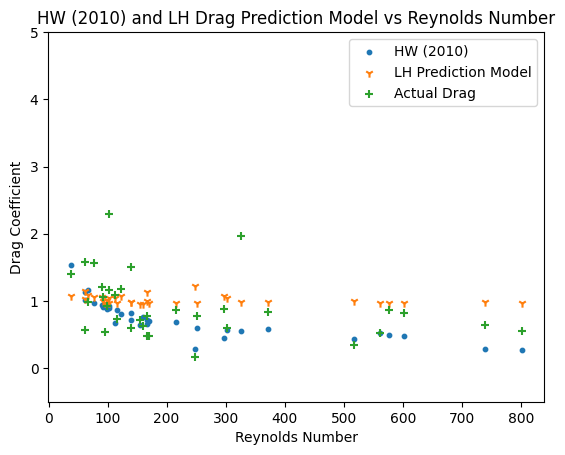

In [293]:
plt.scatter(LH_test['Re_unscaled'], CdHW, s=10)
plt.scatter(LH_test['Re_unscaled'], y_pred,marker="1")
plt.scatter(LH_test['Re_unscaled'], LH_test['Drag Coefficient'], marker='+')
plt.legend(['HW (2010)','LH Prediction Model', 'Actual Drag'])
plt.xlabel('Reynolds Number')
plt.ylabel('Drag Coefficient')
plt.ylim((-.5,5))
plt.title('HW (2010) and LH Drag Prediction Model vs Reynolds Number')

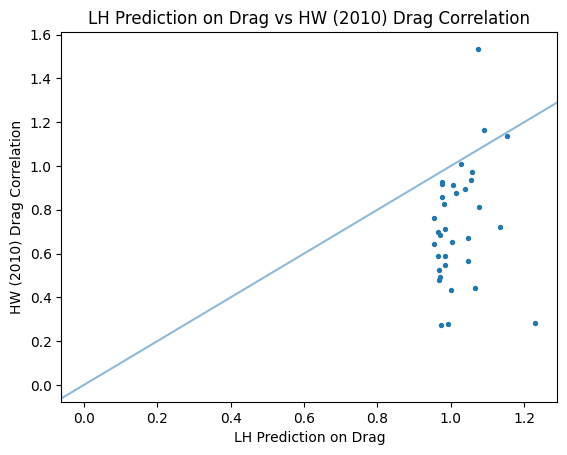

In [308]:
plt.scatter(y_pred,CdHW, s=8)
plt.xlabel('LH Prediction on Drag')
plt.ylabel('HW (2010) Drag Correlation')
plt.title('LH Prediction on Drag vs HW (2010) Drag Correlation')
plt.axline((0, 0), slope=1, alpha=0.5)

Text(0.5, 1.0, 'LH Prediction Model on Drag Error Graph')

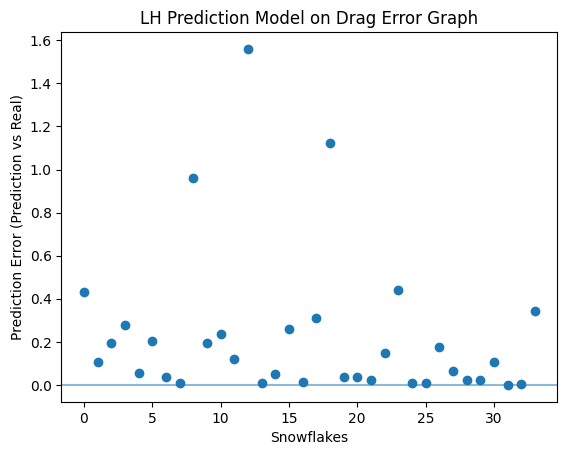

In [302]:
plt.scatter([i for i in range(len(error))], error)

plt.axline((0,0), slope=0, alpha=0.5)
plt.xlabel('Snowflakes')
plt.ylabel('Prediction Error (Prediction vs Real)')
plt.title('LH Prediction Model on Drag Error Graph')

In [305]:
percent_error = [abs(i-j)**2 for i,j in zip(y_pred, y_test)]
#torch.mean(torch.stack(percent_error)) # % error
np.mean(percent_error)

0.22328670291527727

In [309]:
np.mean([[abs(i-j)**2 for i,j in zip(CdHW, y_test)]])


0.21449764701040733

In [307]:
error_percent = [abs(i-j)/i*100 for i,j in zip(y_pred,y_test)]
np.mean(error_percent)

36.29877309106537

In [146]:
shape_dict = {'shapeClass' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
              'shapeName' : ['bALP7a', 'bALS3', 'bAP7a', 'bAR2b', 'bAS3', 'bHP7b', 'bR1a', 'bR1b', 'bR2a', 'bR2b', 'rR3a', 'bR3b', 'bR4a', 'bR4b', 'bR4c', 'unknown']}
shape_df = pd.DataFrame(shape_dict)

shape_mapping = dict(zip(shape_df['shapeClass'], shape_df['shapeName']))

LH_test['shape_names'] = [shape_mapping[int_val] for int_val in LH_test['shapes']]
LH_test['y_pred'] = y_pred

/var/folders/pr/bp0lc7094mjgz3bddb8d1h700000gn/T/ipykernel_33144/2679214401.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 16)


Text(0.5, 1.0, 'Drag Prediction from LH Model vs Reynolds Number')

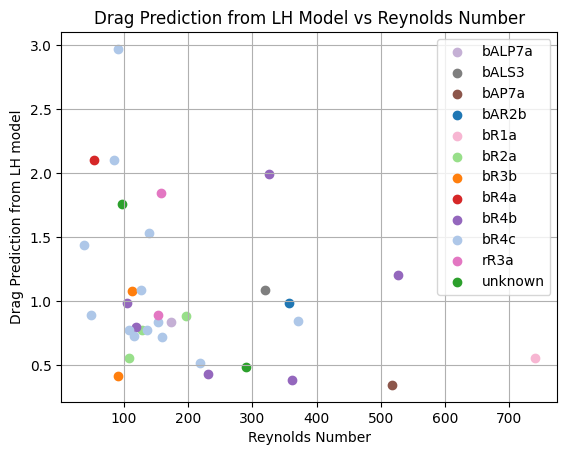

In [158]:
colors = plt.cm.get_cmap('tab20', 16)

for shape, group in LH_test.groupby('shape_names'):
    plt.scatter(group['Re_unscaled'], group['y_pred'], label=shape, color=colors(LH_test['shape_names'].unique().tolist().index(shape)))


#plt.scatter(LH_test['Re_unscaled'], LH_test['y_pred'], s=10)
plt.legend()
plt.grid(True)
plt.ylabel('Drag Prediction from LH model')
plt.xlabel('Reynolds Number')
plt.title('Drag Prediction from LH Model vs Reynolds Number')